In [1]:
import sys
sys.path.append('../')
from hypgs.models.hsn_pyg import HSN
from hypgs.utils.plot import plot_wavelets, get_hyperedge_pos_df, compute_enlarged_hulls, plot_hulls
from hypgs.utils.graph_build import calcualte_voronoi_from_coords, build_graph_from_cell_coords, build_graph_from_voronoi_polygons, build_voronoi_polygon_to_cell_mapping, plot_voronoi_polygons, plot_graph, assign_attributes
from hypgs.models.hsn_pyg import HyperScatteringModule
from hypgs.utils.data import get_hyperedge_index
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils.convert import from_networkx
from hypgs.utils.data import HGDataset
from dhg import Hypergraph
import scprep
import matplotlib.pyplot as plt
import re
import phate
from phate.cluster import kmeans

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops12split_Tensor4callERKNS_6TensorEN3c106SymIntEl
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.con

In [2]:
ae_emb = np.load('ae_embedding_recon_only.npy')

In [3]:
adata_subset = sc.read_h5ad("../data/A23-290-CP_preprocessed_gentle_subset.h5ad")

In [4]:
coordinates = adata_subset.obsm['X_spatial']
coordinates = coordinates - coordinates.min(axis=0)
xmax, ymax = coordinates.max(axis=0)
voronoi_polygons = calcualte_voronoi_from_coords(coordinates[:, 0], coordinates[:, 1])
cell_data = pd.DataFrame(np.c_[adata_subset.obs.index, coordinates], columns=['CELL_ID', 'X', 'Y'])
G, node_to_cell_mapping = build_graph_from_cell_coords(cell_data, voronoi_polygons)
G = assign_attributes(G, cell_data, node_to_cell_mapping)

In [5]:
x_pcs = np.load("../data/A23-290-CP_preprocessed_gentle_subset_PC.npz")
pca_loadings = x_pcs['pca_loadings']

In [6]:
X_cmbn = pca_loadings
data = from_networkx(G)
data.x = torch.tensor(X_cmbn)
original_dataset = [data]
to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, 2)
dataset = HGDataset(original_dataset, to_hg_func)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/torch_geometric/utils/convert.py:260: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_new.cpp:230.)
  data[key] = torch.tensor(value)
Converting to hypergraph data: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


In [7]:
adata_magic = sc.read_h5ad("../data/A23-290-CP_preprocessed_gentle_subset_magic.h5ad")

In [8]:
markers = adata_magic.var_names

In [9]:
model = HyperScatteringModule(in_channels=X_cmbn.shape[1], 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              normalize='right', 
              reshape=False,
        )

In [10]:
from hypgs.utils.hyperedge_aggregator import compute_mean, compute_cov

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
markers_tensor = torch.tensor(adata_magic.X, dtype=torch.float32).to(device)
x = markers_tensor.to(device)
edge_index = dataset[0].edge_index.to(device)
x = (x - x.mean()) / x.std()
he_means = compute_mean(x, edge_index)
he_covs = compute_cov(x, edge_index)

In [12]:
he_means = he_means.cpu().numpy()
he_covs = he_covs.cpu().numpy()

In [13]:
he_covs.shape

(4999, 5, 5)

In [14]:
he_vars = np.array([np.diagonal(cov) for cov in he_covs])

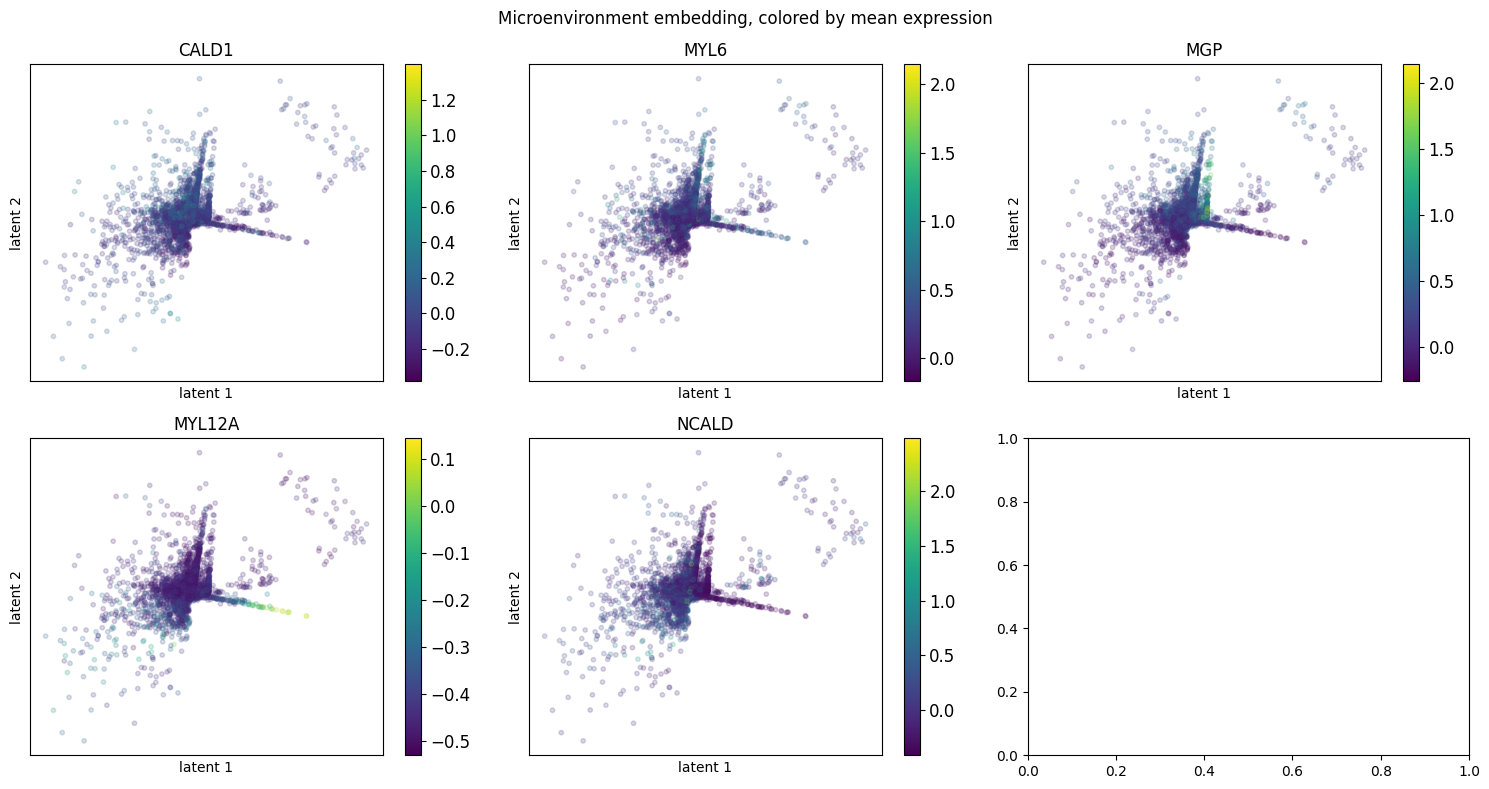

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, marker in enumerate(markers):
    # node_feat = adata_magic[:, marker].X.toarray()
    node_feat = he_means[:,i]
    ax = axes[i // 3, i % 3]
    scprep.plot.scatter2d(ae_emb, c=node_feat, s=10, alpha=0.2, ax=ax, colorbar=True, cmap='viridis')
    ax.set_xlabel('latent 1')
    ax.set_ylabel('latent 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{marker}')
plt.suptitle("Microenvironment embedding, colored by mean expression")
plt.tight_layout()
plt.show()


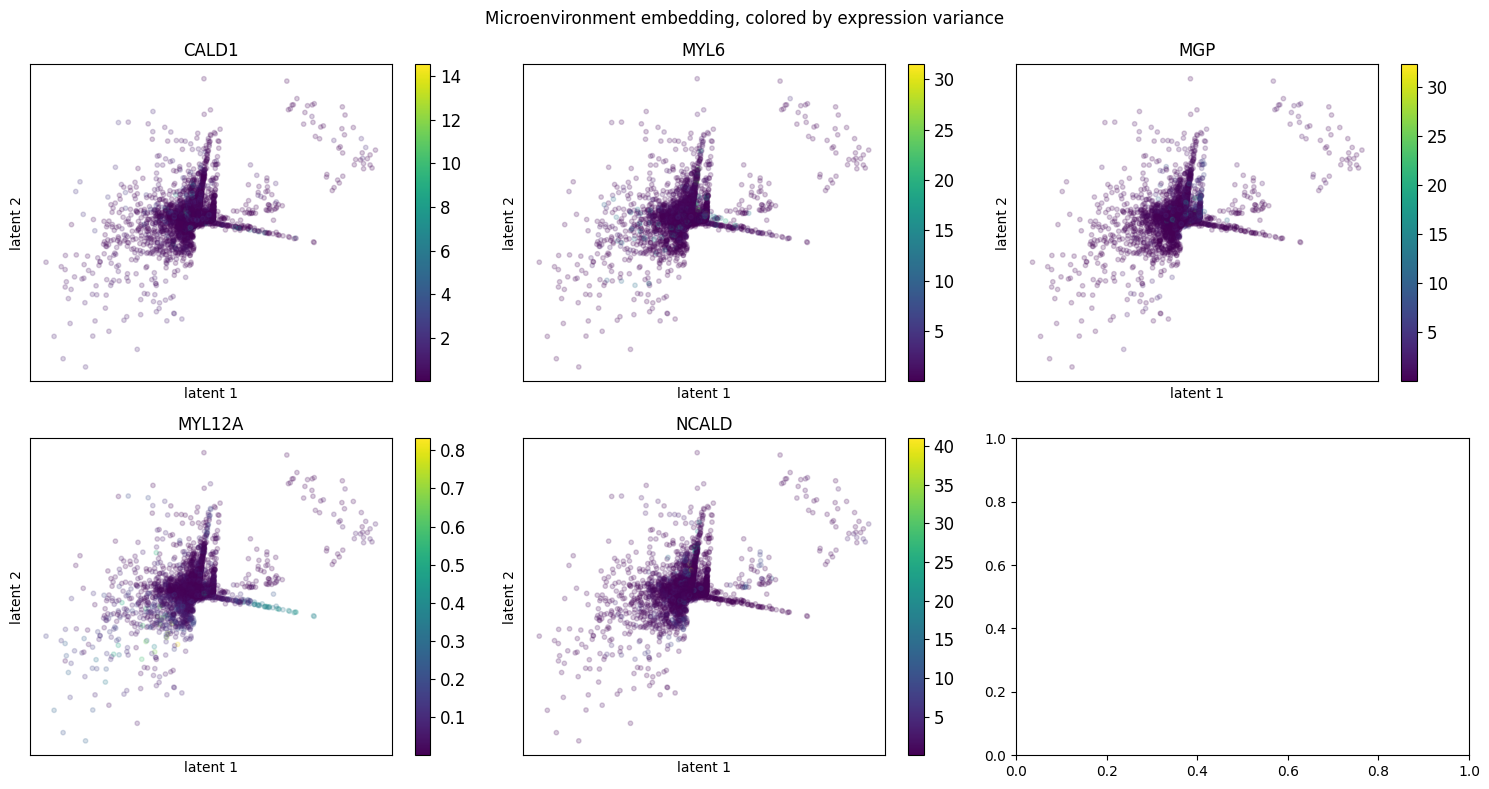

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, marker in enumerate(markers):
    # node_feat = adata_magic[:, marker].X.toarray()
    node_feat = he_vars[:,i]
    ax = axes[i // 3, i % 3]
    scprep.plot.scatter2d(ae_emb, c=node_feat, s=10, alpha=0.2, ax=ax, colorbar=True, cmap='viridis')
    ax.set_xlabel('latent 1')
    ax.set_ylabel('latent 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{marker}')
plt.suptitle("Microenvironment embedding, colored by expression variance")
plt.tight_layout()
plt.show()


In [17]:
eidf = get_hyperedge_pos_df(dataset[0], coordinates)
enlarged_hulls = compute_enlarged_hulls(eidf)

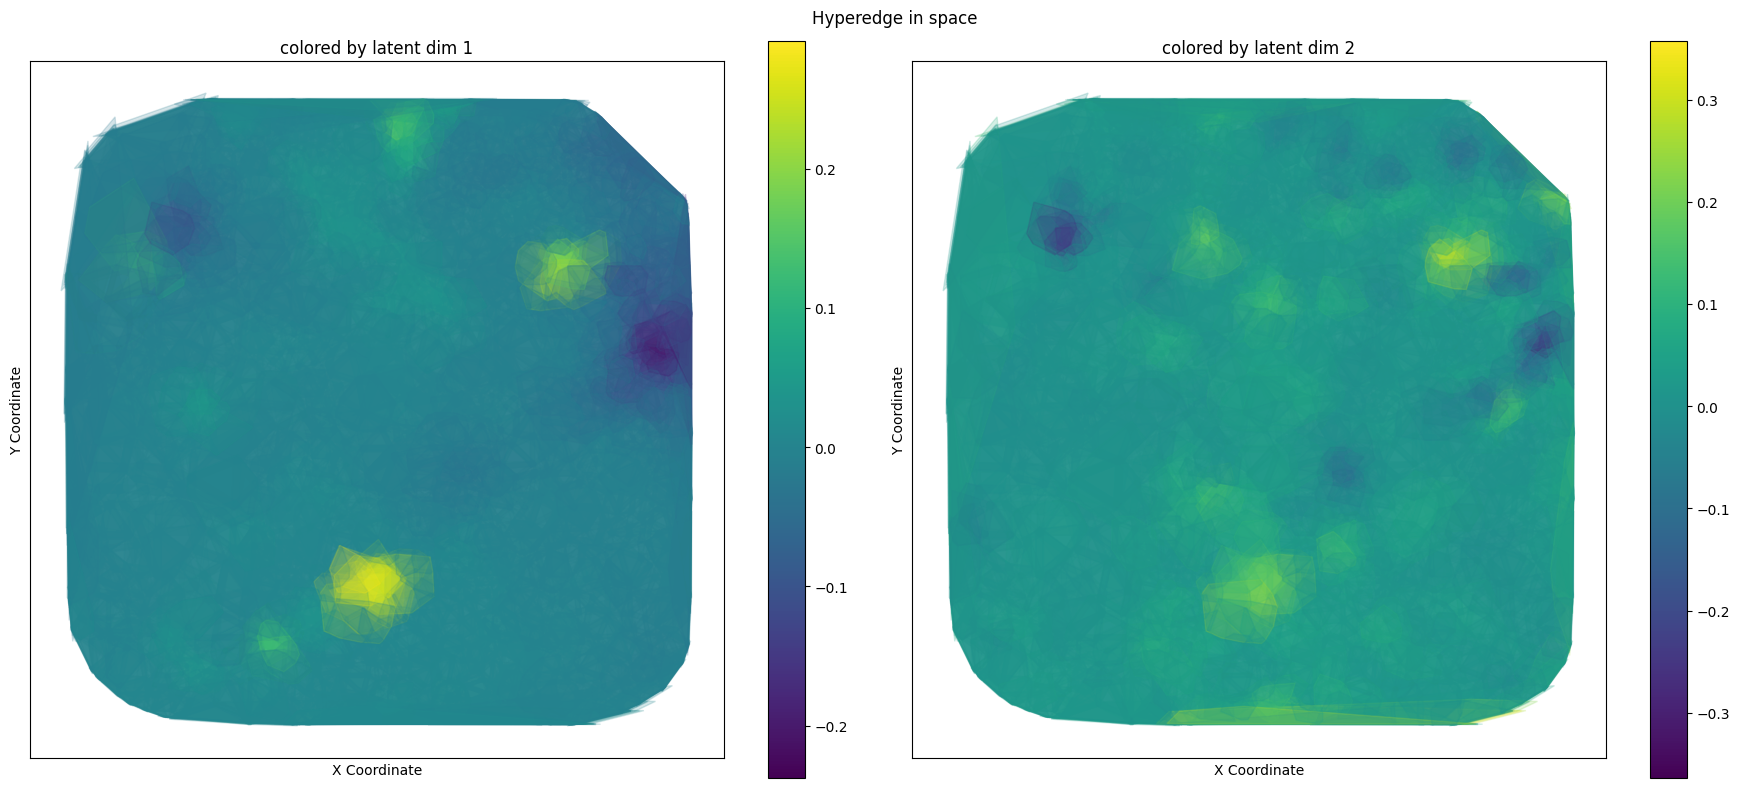

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plot_hulls(enlarged_hulls, ae_emb[:,0], colormap=plt.cm.viridis, alpha=0.2, ax=axes[0])
plot_hulls(enlarged_hulls, ae_emb[:,1], colormap=plt.cm.viridis, alpha=0.2, ax=axes[1])
axes[0].set_title(f'colored by latent dim 1')
axes[1].set_title(f'colored by latent dim 2')
plt.suptitle("Hyperedge in space")
plt.tight_layout()
plt.show()

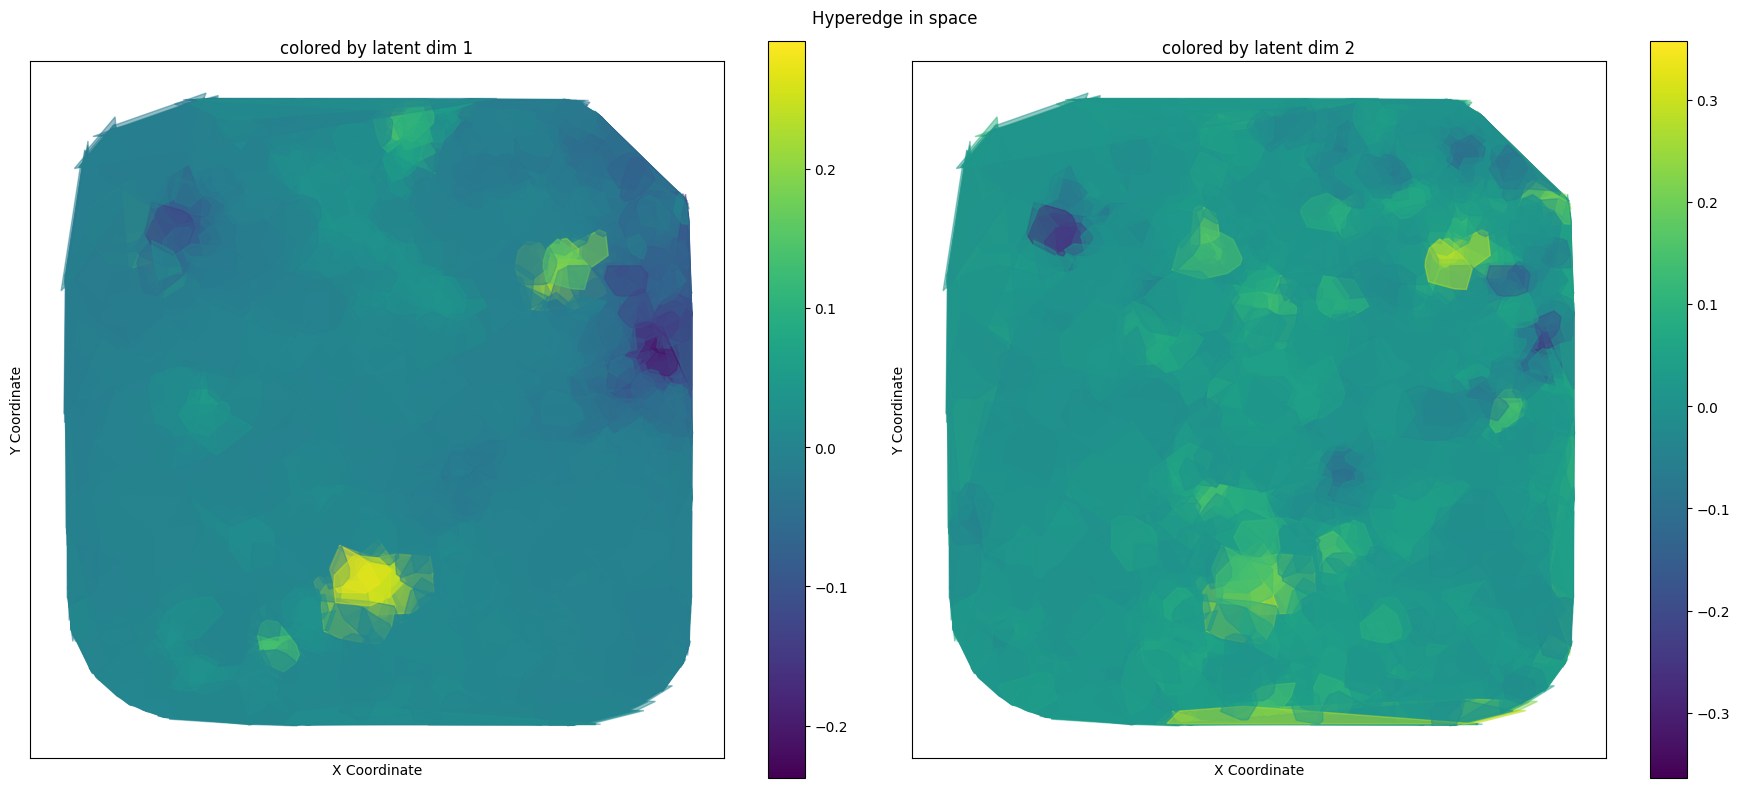

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plot_hulls(enlarged_hulls, ae_emb[:,0], colormap=plt.cm.viridis, alpha=0.5, ax=axes[0])
plot_hulls(enlarged_hulls, ae_emb[:,1], colormap=plt.cm.viridis, alpha=0.5, ax=axes[1])
axes[0].set_title(f'colored by latent dim 1')
axes[1].set_title(f'colored by latent dim 2')
plt.suptitle("Hyperedge in space")
plt.tight_layout()
plt.show()

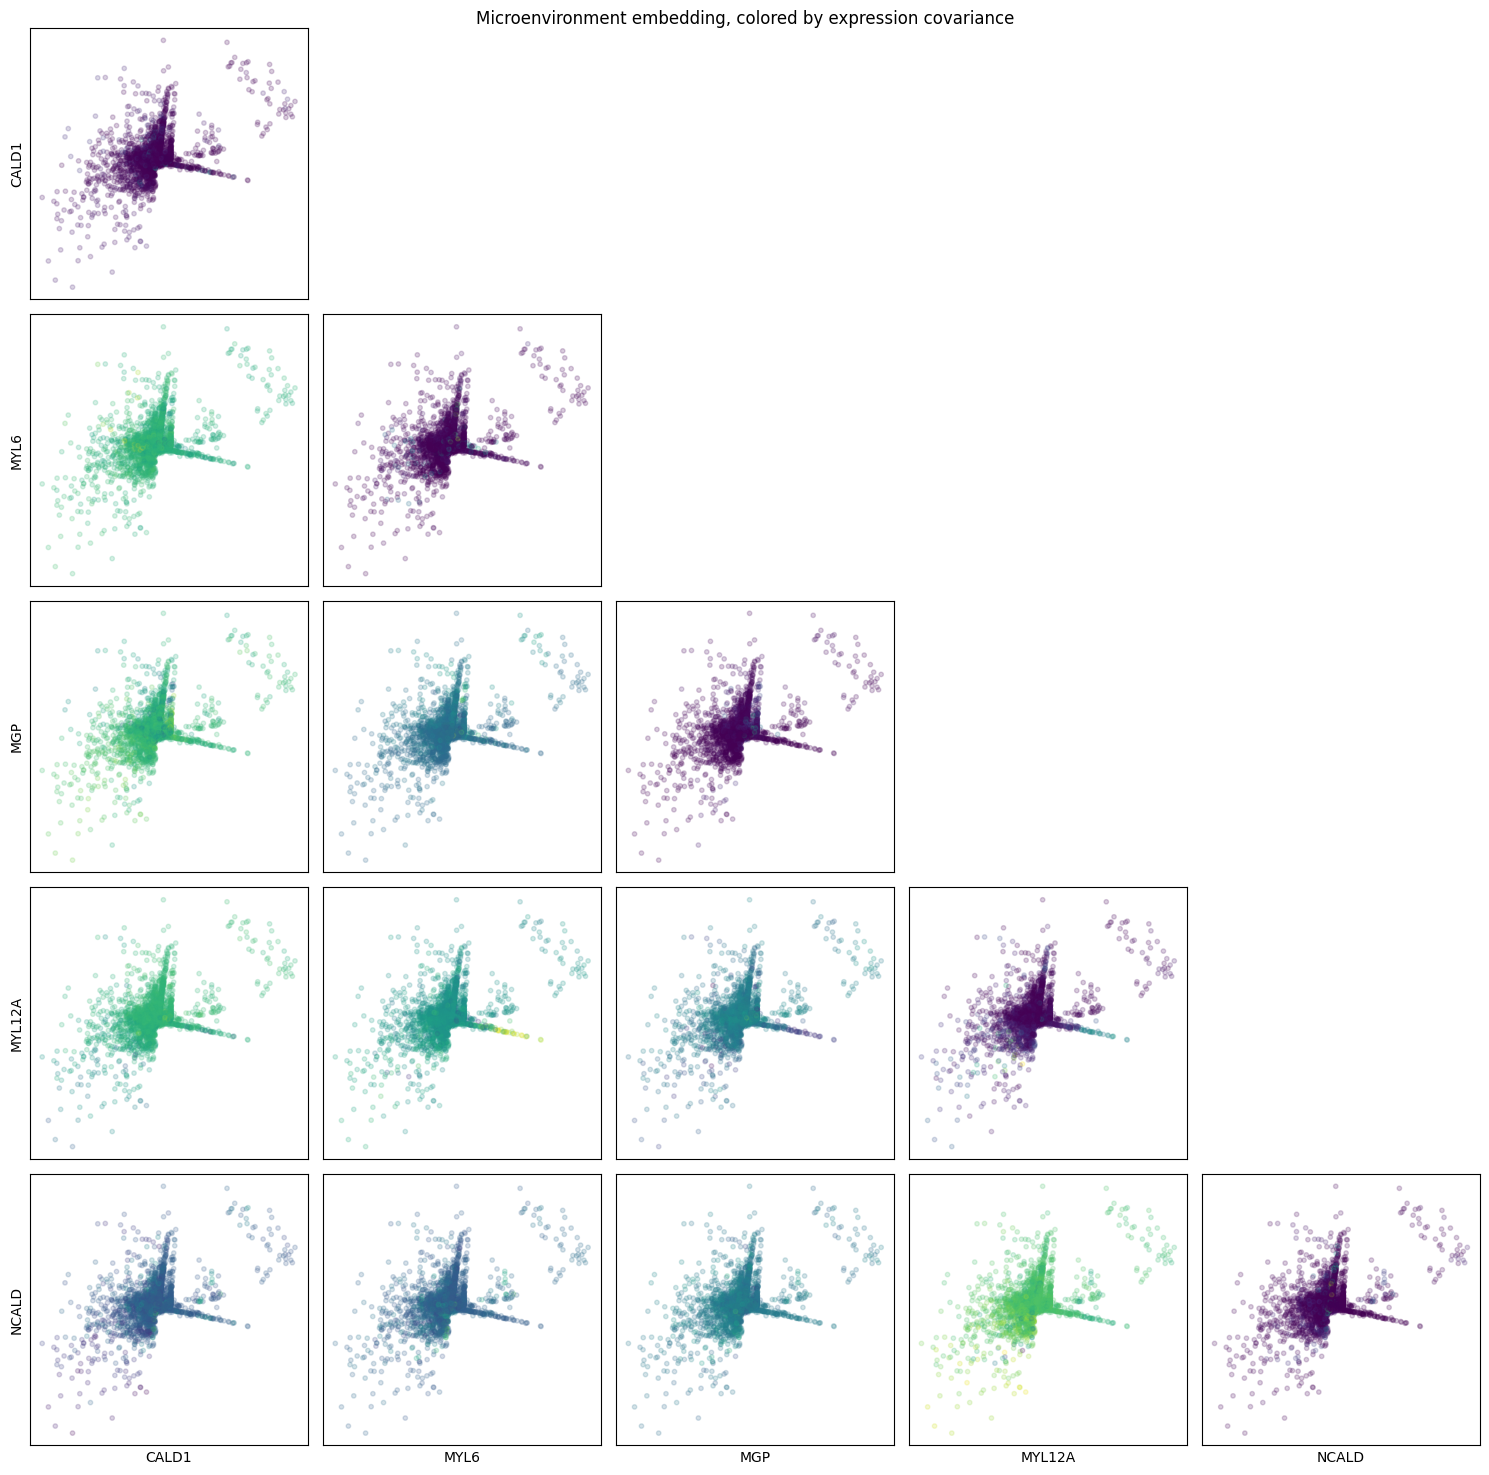

In [20]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, marker1 in enumerate(markers):
    for j, marker2 in enumerate(markers):
        ax = axes[i,j]
        if i >= j: # Upper off-diagonal, plot heatmap
            node_feat = he_covs[:,i,j]
            scprep.plot.scatter2d(ae_emb, c=node_feat, s=10, alpha=0.2, ax=ax, colorbar=False, cmap='viridis')
            # ax.set_xlabel('latent 1')
            # ax.set_ylabel('latent 2')
            ax.set_xticks([])
            ax.set_yticks([])
            # ax.set_title(f'{marker}')
        else:
            ax.axis('off')
        
        if i == len(markers) - 1:
            # Set x-axis label for the last row
            ax.set_xlabel(markers[j])
            # ax.set_xticks([0.5])  # Put the label at the center; adjust as needed
            # ax.set_xticklabels([markers[j]])

        if j == 0:
            # Set y-axis label for the first column
            ax.set_ylabel(markers[i])
            # ax.set_yticks([0.5])  # Put the label at the center; adjust as needed
            # ax.set_yticklabels([markers[i]])

plt.suptitle("Microenvironment embedding, colored by expression covariance")
plt.tight_layout()
plt.show()